In [130]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.base import clone
warnings.filterwarnings('ignore')

%run helper.ipynb import *

In [6]:
!python -m venv myvenv
!source myvenv/bin/activate
!python -m pip install -r requirements.txt

'source' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Phase 1

In [131]:
dataset = pd.read_csv('datasets/Dataset1.csv')
dataset

Label  Feature 1  Feature 2
0         0    660.976    304.225
1         0    636.213    306.174
2         0    662.753    307.565
3         0    657.487    307.740
4         0    635.273    308.157
...     ...        ...        ...
3026      8    554.716    460.908
3027      8    577.082    461.731
3028      8    569.221    462.349
3029      8    556.636    464.758
3030      8    557.293    465.752

[3031 rows x 3 columns]

In [132]:
unique_labels = dataset['Label'].unique()
print('unique labels: ', unique_labels)

print('length dataset: ', len(dataset))

unique labels:  [0 1 2 3 4 5 6 7 8]
length dataset:  3031


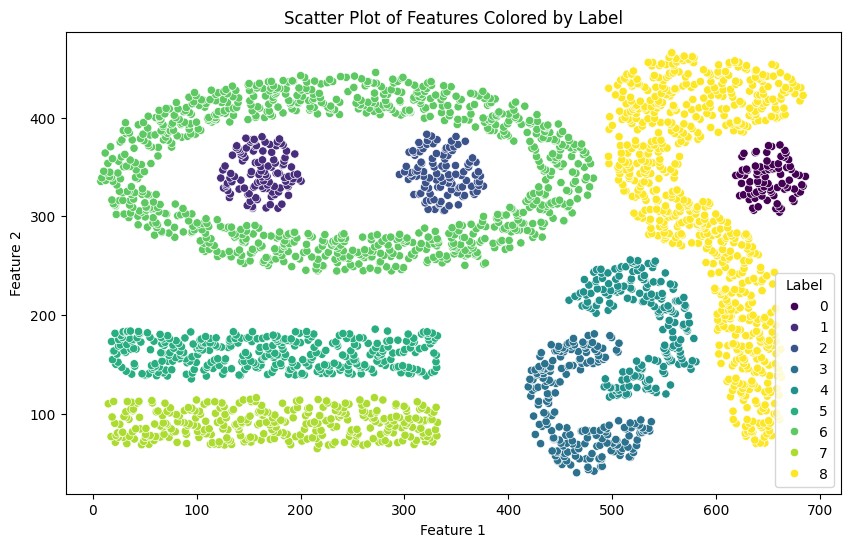

In [133]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataset, x='Feature 1', y='Feature 2', hue='Label', palette='viridis', legend='full')
plt.title('Scatter Plot of Features Colored by Label')
plt.show()


In [134]:
X = dataset.iloc[:, 1:]
y = dataset.iloc[:, :1]

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [136]:
X_2d = X_test.iloc[:, :2].values 

x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

## 1.1 Aggregating Bootstrap(Bagging)

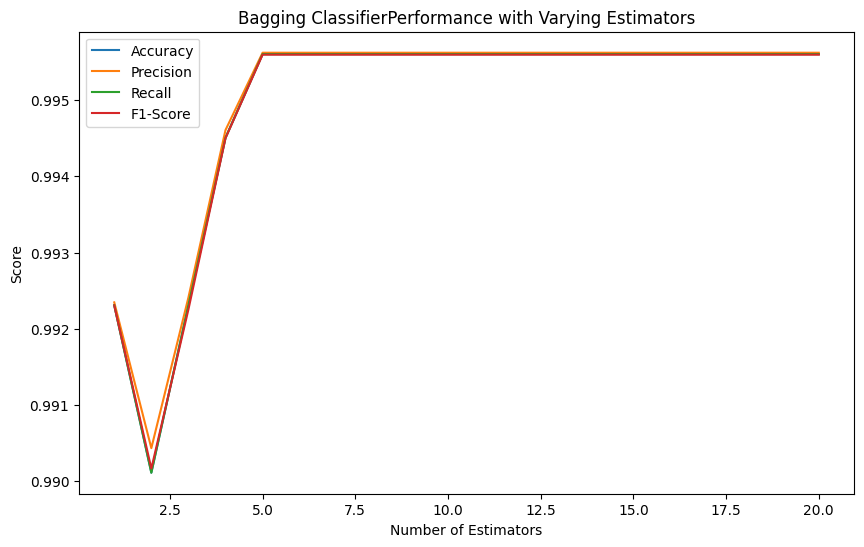

In [137]:
n_estimators = range(1, 21)  # Testing with 1 to 20 estimators
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for n in n_estimators:
    bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n, random_state=42)
    bagging_clf.fit(X_train, y_train)
    
    y_pred = bagging_clf.predict(X_test)
    
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='weighted'))
    recall_list.append(recall_score(y_test, y_pred, average='weighted'))
    f1_list.append(f1_score(y_test, y_pred, average='weighted'))

# Plotting the results
plot_ensemble_classifer_result(model_name='Bagging Classifier', n_estimators=n_estimators, accuracy_list=accuracy_list,
                               precision_list=precision_list, recall_list=recall_list, f1_list=f1_list)

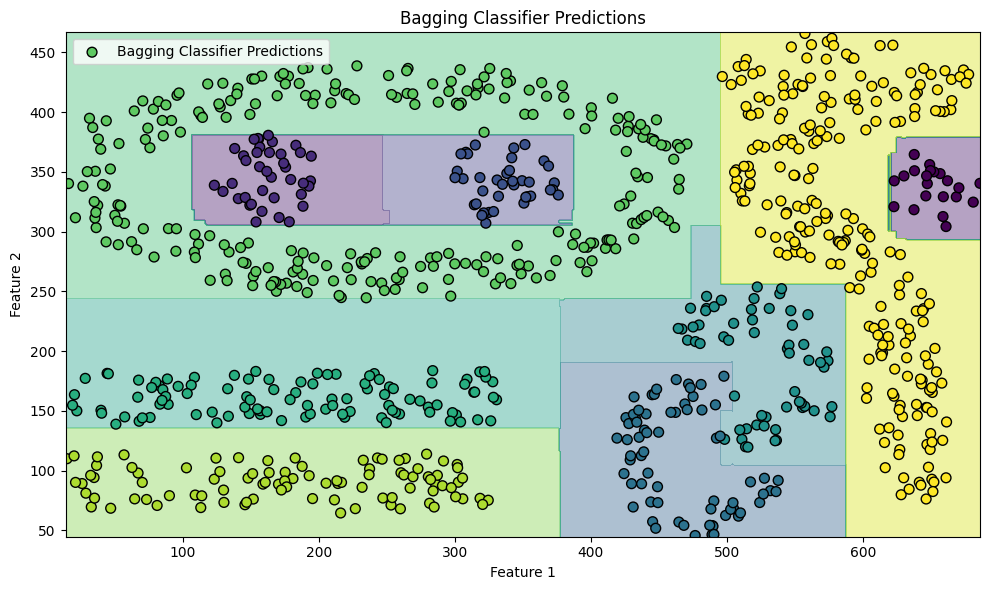

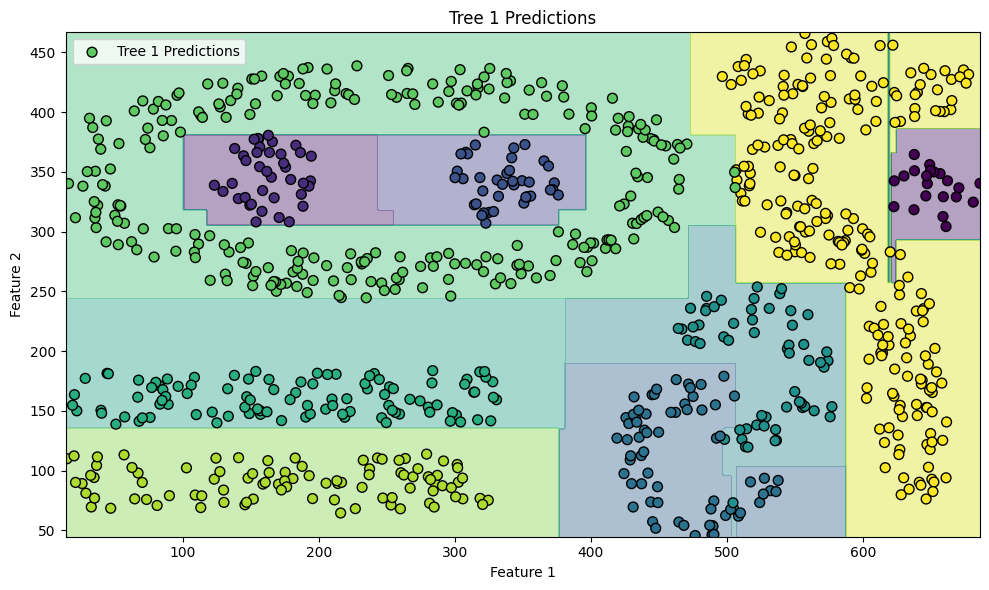

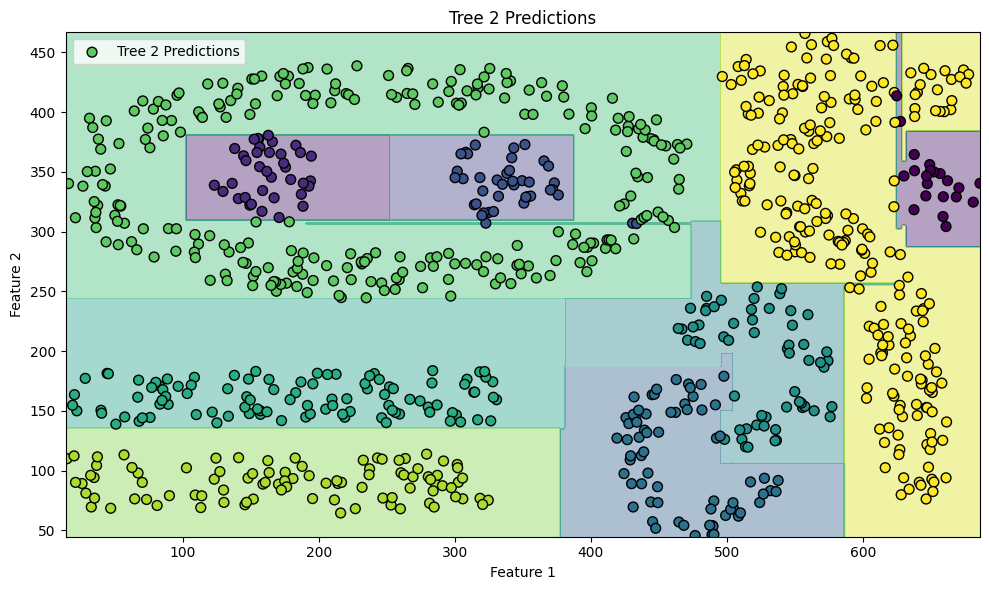

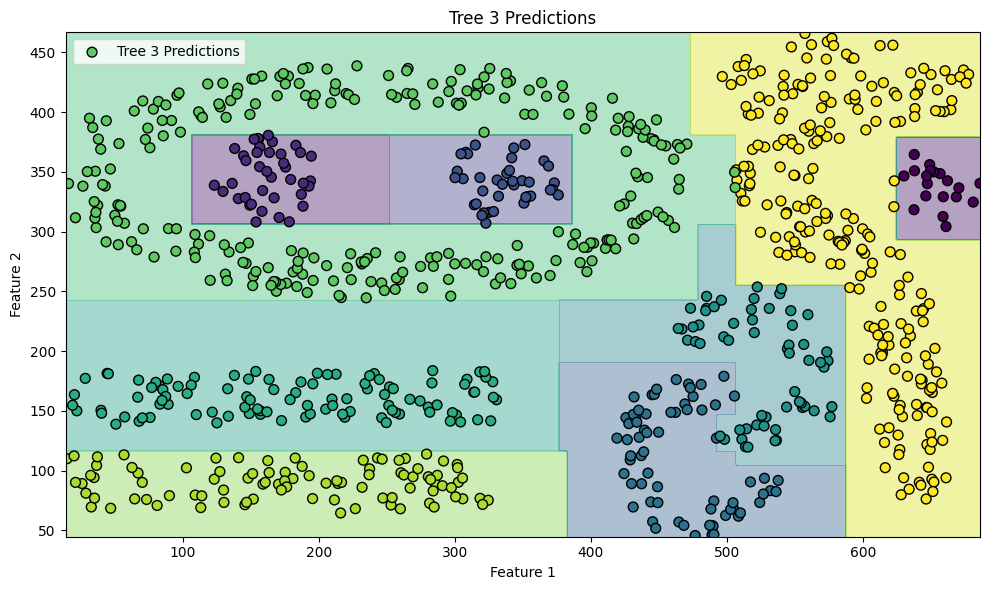

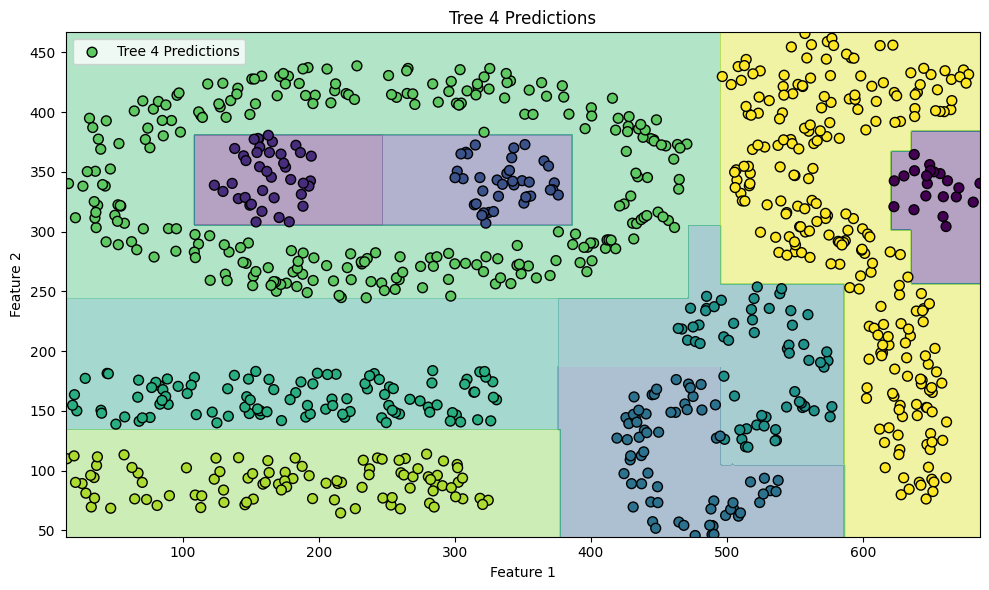

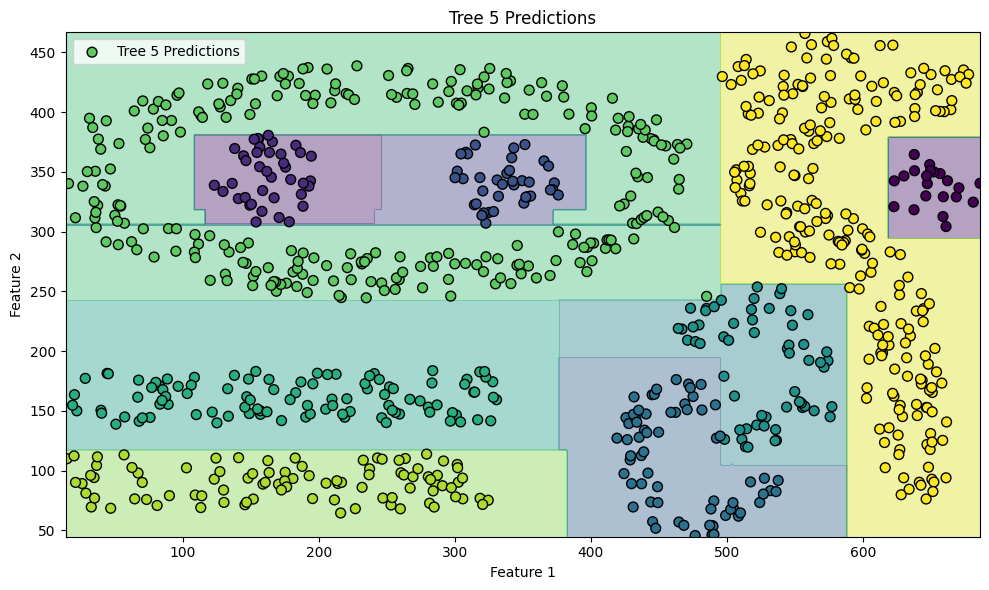

In [138]:
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=7, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred = bagging_clf.predict(X_test)

# Visualize Bagging predictions

Z = bagging_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_pred, xx=xx, yy=yy, Z=Z, classifer_name='Bagging Classifier Predictions')


# Visualize predictions of 5 decision trees
for i, estimator in enumerate(bagging_clf.estimators_[:5]):
    y_tree_pred = estimator.predict(X_test)
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_tree_pred, xx=xx, yy=yy, Z=Z, classifer_name=f'Tree {i+1} Predictions')
    
    # plt.contourf(xx, yy, Z, alpha=0.4)


In [140]:
y_train_pred = bagging_clf.predict(X_train)
y_test_pred = bagging_clf.predict(X_test)

performance_data = {
    'Model': [],
    'Dataset': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Bagging classifier performance
add_performance_data(model_name='Bagging Classifier', dataset='Train', y_true=y_train,
                      y_pred=y_train_pred, performance_data=performance_data)
add_performance_data(model_name='Bagging Classifier', dataset='Test', y_true=y_test, 
                     y_pred=y_test_pred, performance_data=performance_data)

# Individual decision trees performance on the test set
for i, estimator in enumerate(bagging_clf.estimators_):
    y_train_tree_pred = estimator.predict(X_train)
    y_test_tree_pred = estimator.predict(X_test)
    add_performance_data(model_name=f'Decision Tree {i+1}', dataset='Train', y_true=y_train,
                          y_pred=y_train_tree_pred, performance_data=performance_data)
    add_performance_data(model_name=f'Decision Tree {i+1}', dataset='Test', y_true=y_test,
                          y_pred=y_test_tree_pred, performance_data=performance_data)

performance_df = pd.DataFrame(performance_data)

performance_df


Model Dataset  Precision    Recall  F1-Score
0   Bagging Classifier   Train   0.999057  0.999057  0.999057
1   Bagging Classifier    Test   0.995622  0.995604  0.995597
2      Decision Tree 1   Train   0.996734  0.996700  0.996703
3      Decision Tree 1    Test   0.992346  0.992308  0.992305
4      Decision Tree 2   Train   0.994400  0.994342  0.994360
5      Decision Tree 2    Test   0.986895  0.986813  0.986809
6      Decision Tree 3   Train   0.996246  0.996228  0.996216
7      Decision Tree 3    Test   0.993461  0.993407  0.993354
8      Decision Tree 4   Train   0.996245  0.996228  0.996233
9      Decision Tree 4    Test   0.994510  0.994505  0.994499
10     Decision Tree 5   Train   0.998111  0.998114  0.998112
11     Decision Tree 5    Test   0.993386  0.993407  0.993381
12     Decision Tree 6   Train   0.995782  0.995757  0.995740
13     Decision Tree 6    Test   0.994517  0.994505  0.994478
14     Decision Tree 7   Train   0.999532  0.999529  0.999529
15     Decision Tree 7    Test   0.996771  0.996703  0.996695

## 1.2 Random Forest

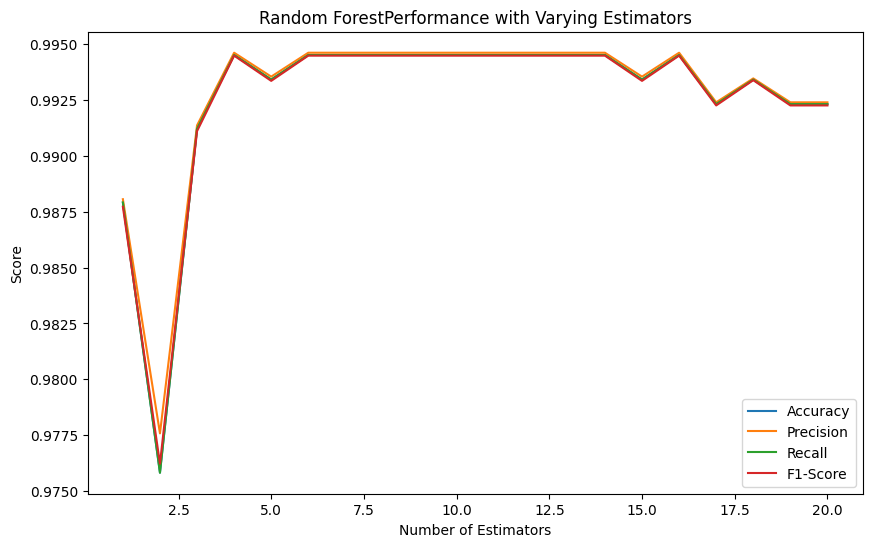

In [141]:
n_estimators = range(1, 21)  # Testing with 1 to 20 estimators
accuracy_list_rf = []
precision_list_rf = []
recall_list_rf = []
f1_list_rf = []

# Implement Random Forest with varying number of estimators
for n in n_estimators:
    rf_clf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_clf.fit(X_train, y_train)
    
    y_pred_rf = rf_clf.predict(X_test)
    
    accuracy_list_rf.append(accuracy_score(y_test, y_pred_rf))
    precision_list_rf.append(precision_score(y_test, y_pred_rf, average='weighted'))
    recall_list_rf.append(recall_score(y_test, y_pred_rf, average='weighted'))
    f1_list_rf.append(f1_score(y_test, y_pred_rf, average='weighted'))

# Plotting the results
plot_ensemble_classifer_result(model_name='Random Forest', n_estimators=n_estimators, accuracy_list=accuracy_list_rf,
                               precision_list=precision_list_rf, recall_list=recall_list_rf, f1_list=f1_list_rf)

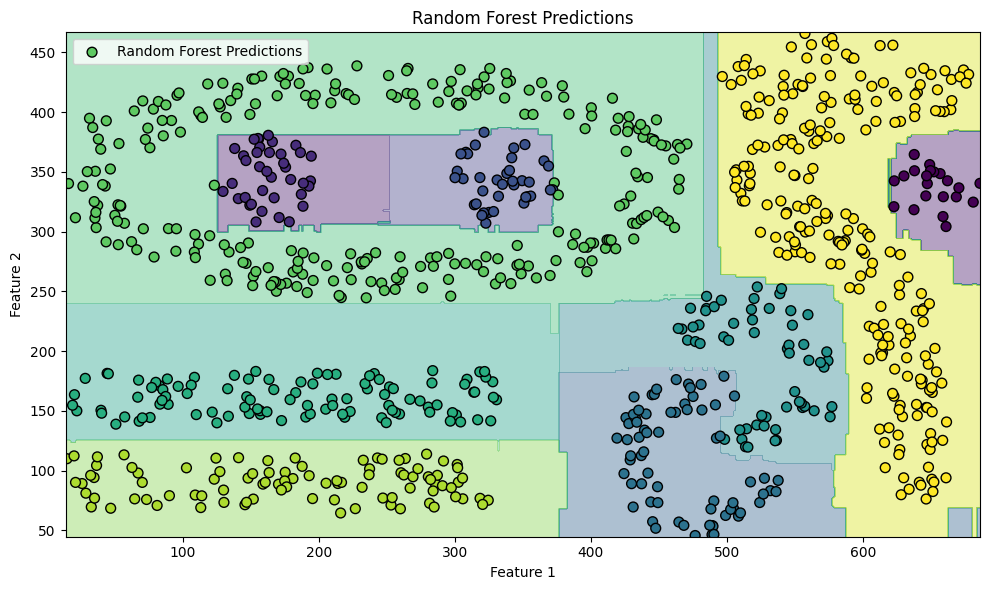

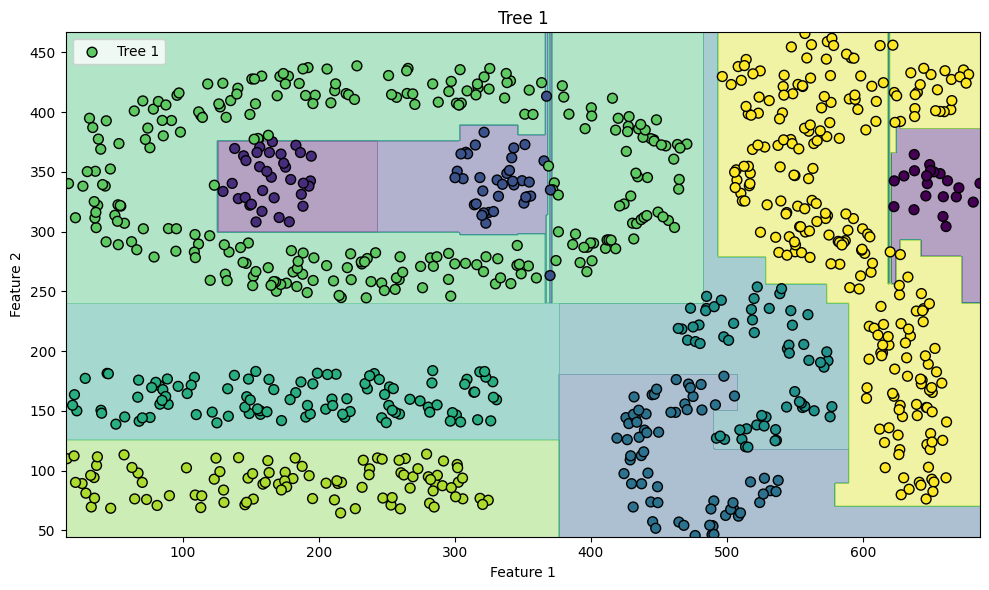

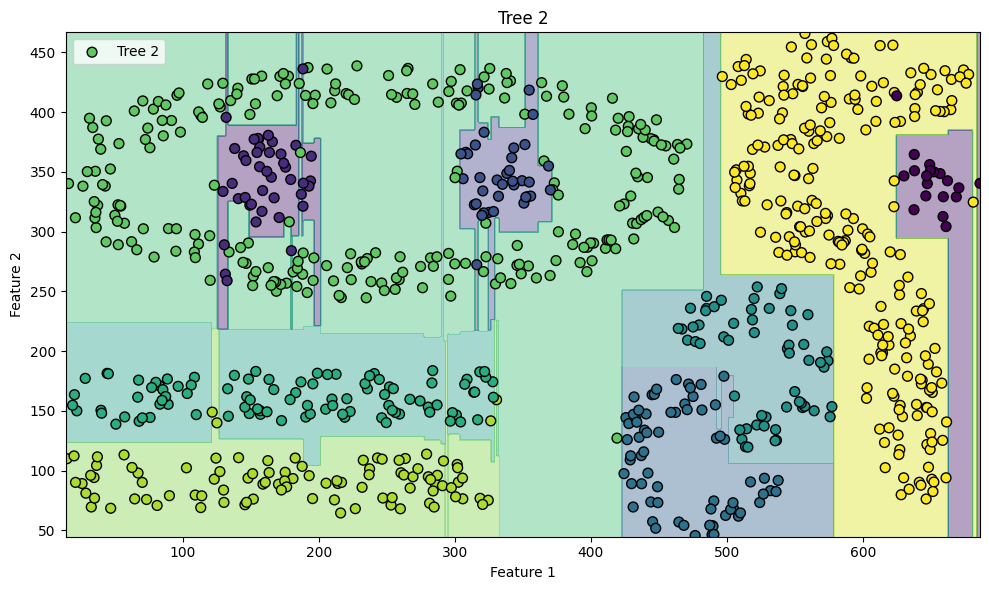

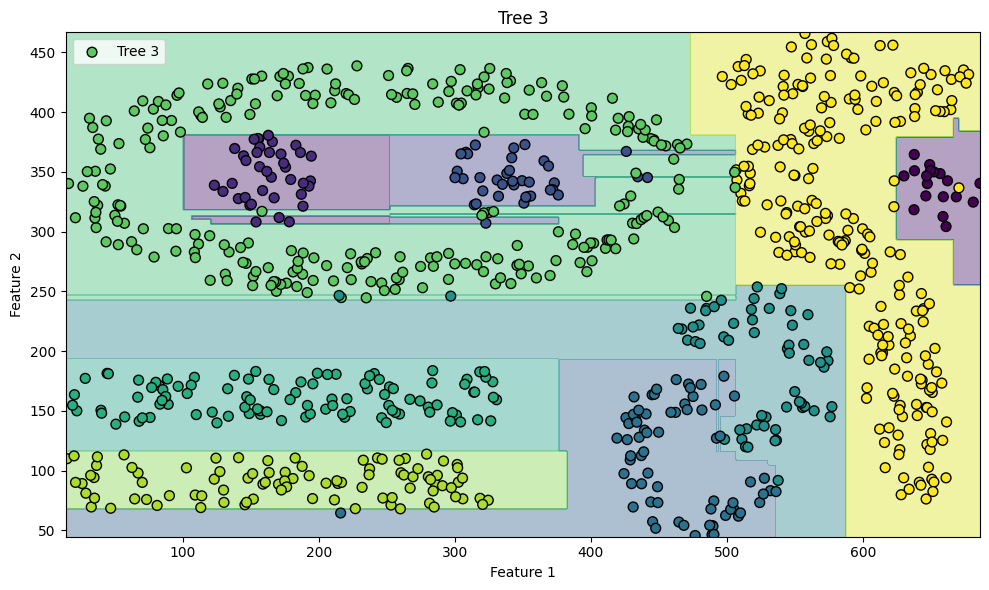

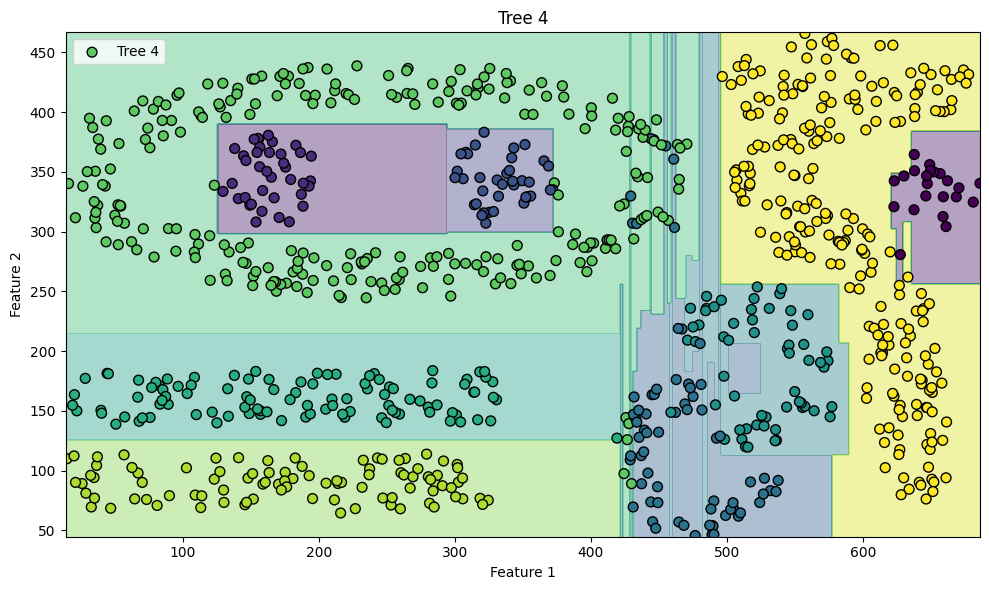

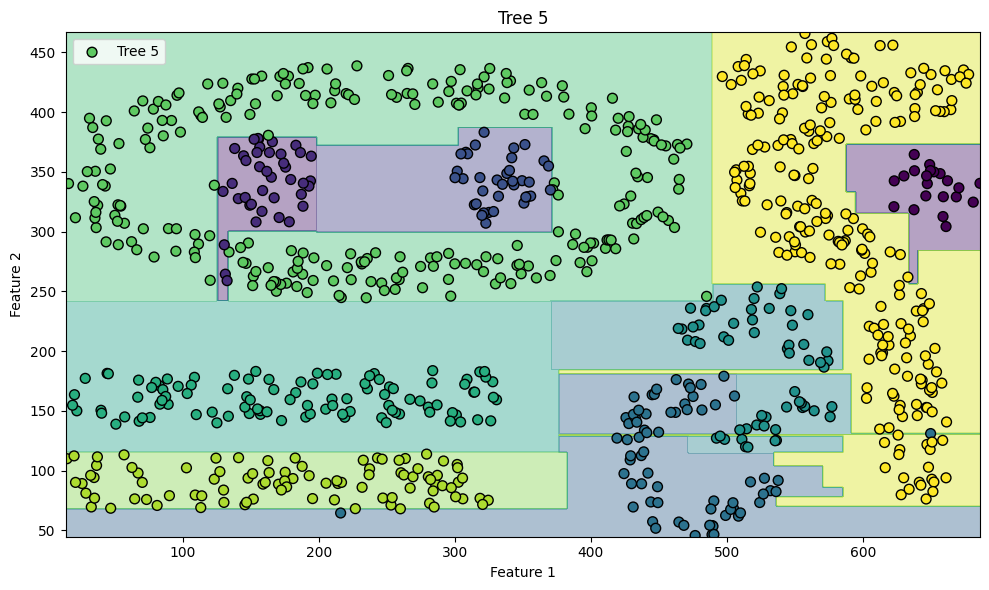

In [142]:
rf_clf = RandomForestClassifier(n_estimators=7, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_clf.predict(X_test)

Z = rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualize the Random Forest classifier predictions
visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_pred_rf, xx=xx, yy=yy, Z=Z, classifer_name='Random Forest Predictions')

# Visualize the predictions of 5 individual decision trees
for i, estimator in enumerate(rf_clf.estimators_[:5]):
    y_tree_pred = estimator.predict(X_test)
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_tree_pred, xx=xx, yy=yy, Z=Z, classifer_name=f'Tree {i+1}')


In [143]:
# Evaluate the Random Forest classifier on the train and test sets
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

performance_data_rf = {
    'Model': [],
    'Dataset': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Random Forest classifier performance
add_performance_data(model_name='Random Forest', dataset='Train', y_true=y_train,
                      y_pred=y_train_pred_rf, performance_data=performance_data_rf)
add_performance_data(model_name='Random Forest', dataset='Test', y_true=y_test,
                      y_pred=y_test_pred_rf, performance_data=performance_data_rf)


# Individual decision trees performance on the test set
for i, estimator in enumerate(rf_clf.estimators_[:5]):
    y_train_tree_pred = estimator.predict(X_train)
    y_test_tree_pred = estimator.predict(X_test)
    	
    add_performance_data(model_name=f'Random Forest Tree {i+1}', dataset='Train', y_true=y_train,
                      y_pred=y_train_tree_pred, performance_data=performance_data_rf)

    add_performance_data(model_name=f'Random Forest Tree {i+1}', dataset='Test', y_true=y_test,
                      y_pred=y_test_tree_pred, performance_data=performance_data_rf)


performance_df_rf = pd.DataFrame(performance_data_rf)

performance_df_rf


Model Dataset  Precision    Recall  F1-Score
0          Random Forest   Train   0.999532  0.999529  0.999529
1          Random Forest    Test   0.994607  0.994505  0.994477
2   Random Forest Tree 1   Train   0.996295  0.996228  0.996236
3   Random Forest Tree 1    Test   0.988057  0.987912  0.987719
4   Random Forest Tree 2   Train   0.983595  0.983498  0.983502
5   Random Forest Tree 2    Test   0.961893  0.961538  0.961489
6   Random Forest Tree 3   Train   0.991967  0.991985  0.991958
7   Random Forest Tree 3    Test   0.977007  0.976923  0.976768
8   Random Forest Tree 4   Train   0.987380  0.987270  0.987257
9   Random Forest Tree 4    Test   0.971831  0.971429  0.971559
10  Random Forest Tree 5   Train   0.993504  0.993399  0.993407
11  Random Forest Tree 5    Test   0.988135  0.987912  0.987917

## 1.3 AdaBoost

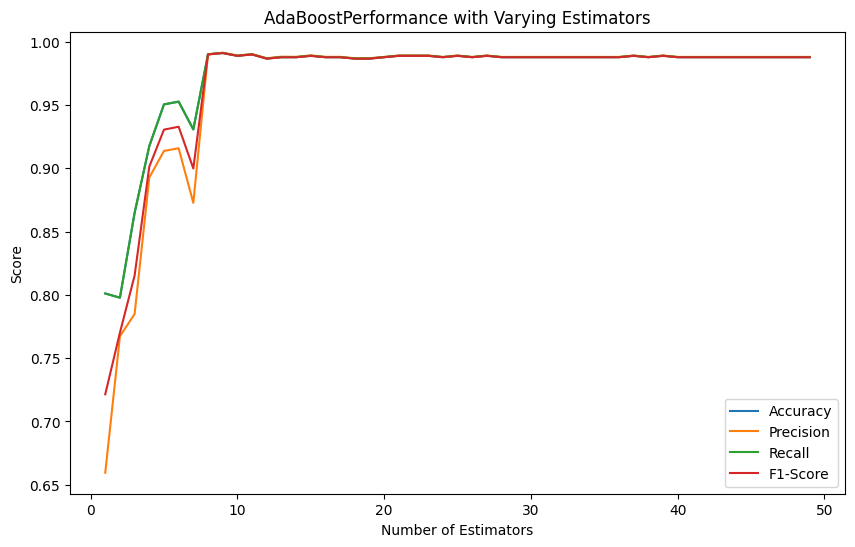

In [144]:
n_estimators = range(1, 50)  # Testing with 1 to 20 estimators
accuracy_list_ada = []
precision_list_ada = []
recall_list_ada = []
f1_list_ada = []

for n in n_estimators:
	ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=n, random_state=42)
	ada_clf.fit(X_train, y_train)

	y_pred_ada = ada_clf.predict(X_test)
	
	accuracy_list_ada.append(accuracy_score(y_test, y_pred_ada))
	precision_list_ada.append(precision_score(y_test, y_pred_ada, average='weighted'))
	recall_list_ada.append(recall_score(y_test, y_pred_ada, average='weighted'))
	f1_list_ada.append(f1_score(y_test, y_pred_ada, average='weighted'))
	

# Plotting the results
plot_ensemble_classifer_result(model_name='AdaBoost', n_estimators=n_estimators, accuracy_list=accuracy_list_ada,
                               precision_list=precision_list_ada, recall_list=recall_list_ada, f1_list=f1_list_ada)

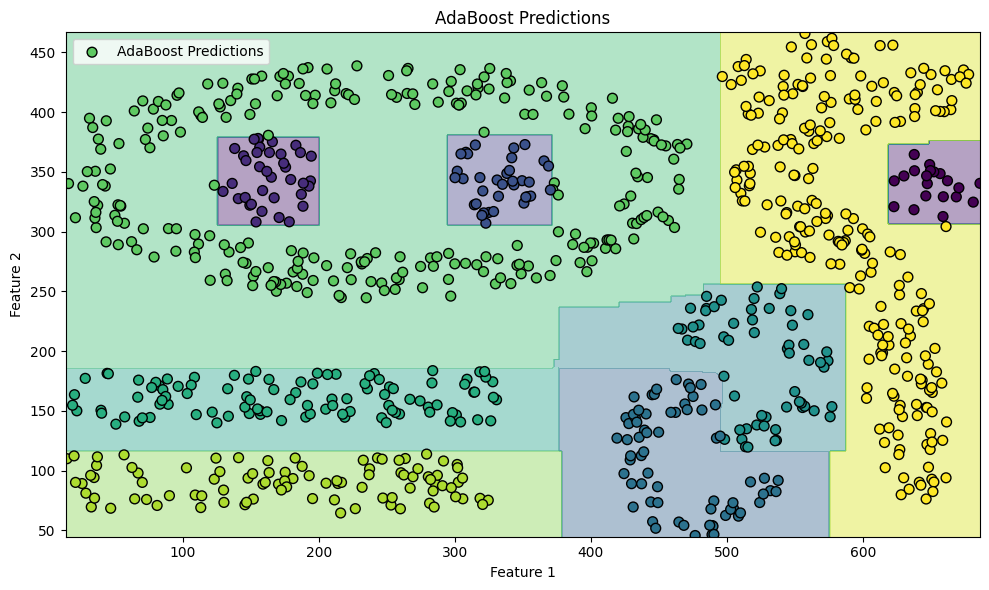

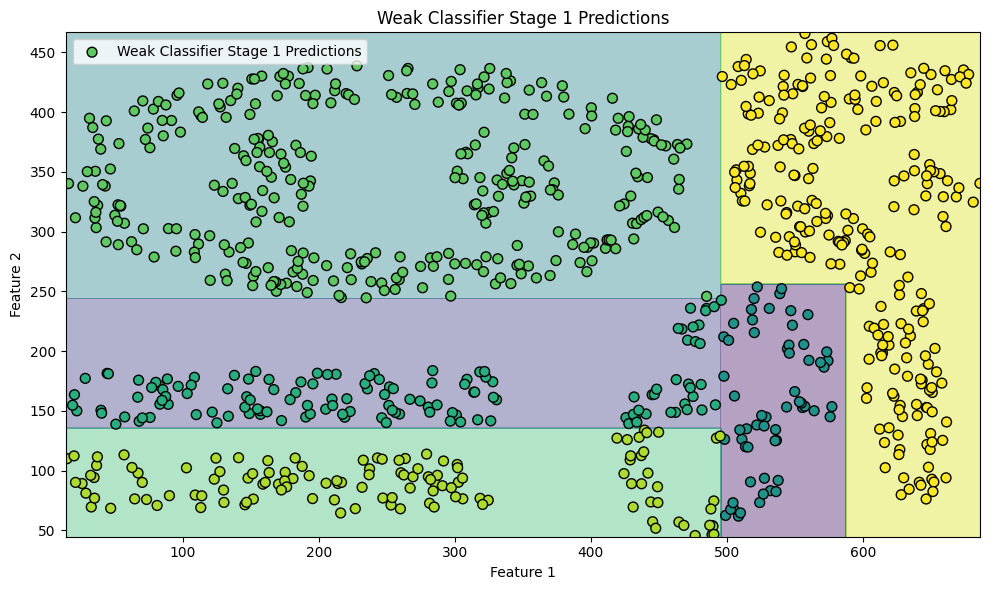

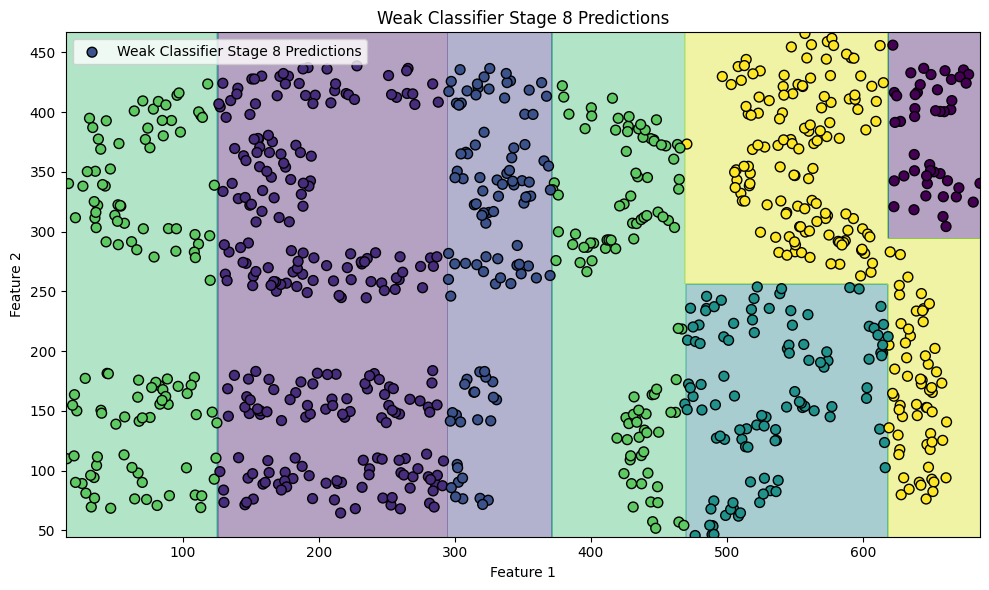

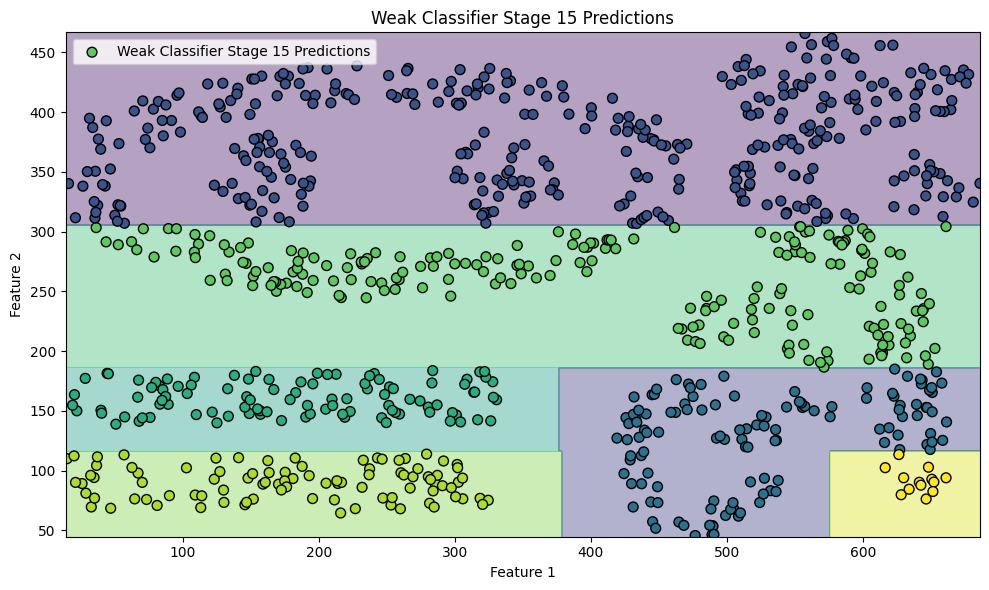

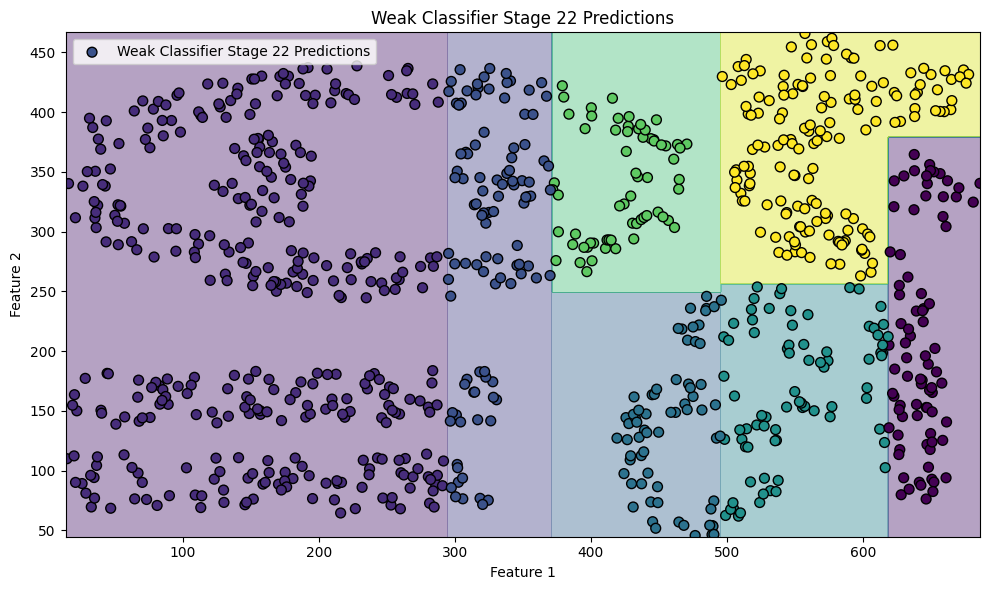

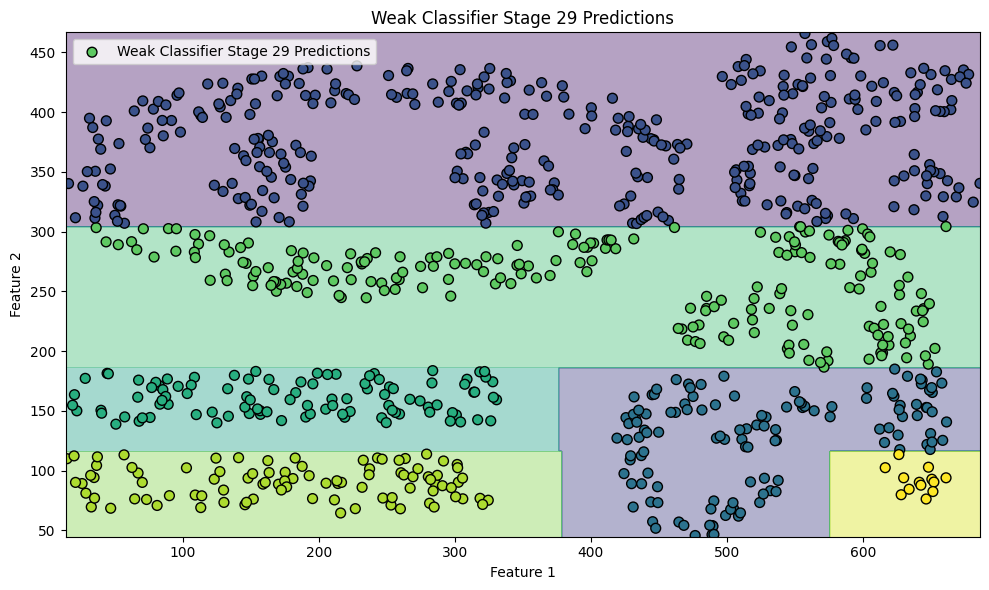

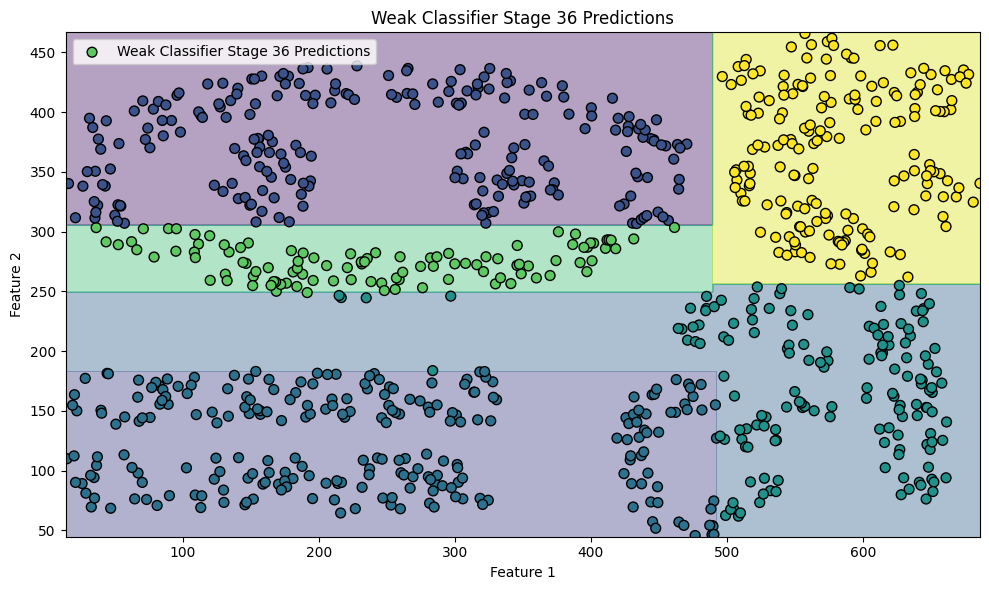

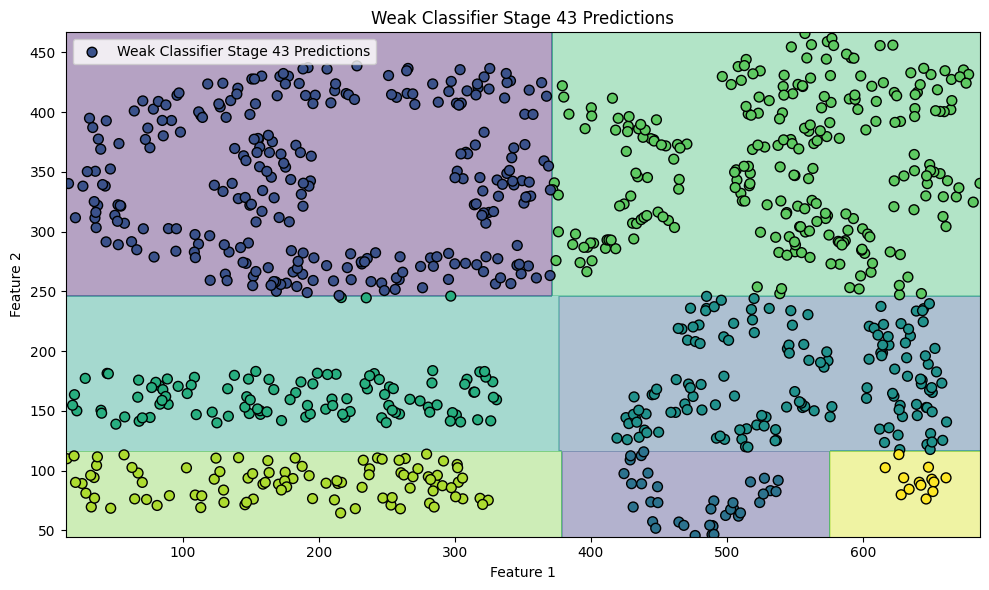

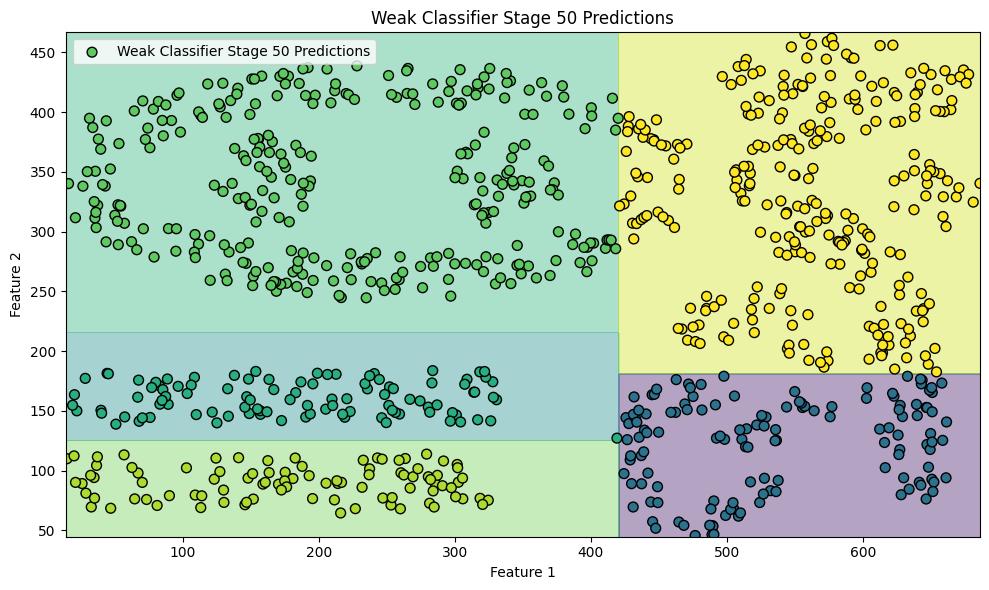

In [145]:
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=3), 
    n_estimators=50,
    random_state=42
)
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)

Z = ada_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualize the AdaBoost classifier predictions
visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_pred_ada, xx=xx, yy=yy,
                                 Z=Z, classifer_name='AdaBoost Predictions')

stages = np.linspace(1, ada_clf.n_estimators, 8, dtype=int)

# Visualize the predictions of weak classifiers at 8 stages
for stage in stages:
    estimator = ada_clf.estimators_[stage-1]
    y_stage_pred = estimator.predict(X_test)
    
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    visualize_classifer_predictions(X_test=X_test, y_test=y_test, y_pred=y_stage_pred, xx=xx, yy=yy, Z=Z,
                                     classifer_name=f'Weak Classifier Stage {stage} Predictions')


In [146]:
y_train_pred_ada = ada_clf.predict(X_train)
y_test_pred_ada = ada_clf.predict(X_test)

performance_data_ada = {
    'Model': [],
    'Dataset': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# AdaBoost classifier performance
add_performance_data(model_name='AdaBoost Classifier', dataset='Train', y_true=y_train,
                      y_pred=y_train_pred_ada, performance_data=performance_data_ada)

add_performance_data(model_name='AdaBoost Classifier', dataset='Test', y_true=y_test,
                      y_pred=y_test_pred_ada, performance_data=performance_data_ada)


# Individual weak classifiers performance on the test set at 8 stages
for stage in stages:
    estimator = ada_clf.estimators_[stage-1]
    y_train_stage_pred = estimator.predict(X_train)
    y_test_stage_pred = estimator.predict(X_test)
    
    add_performance_data(model_name=f'Weak Classifier Stage {stage}', dataset='Train', y_true=y_train, 
                         y_pred=y_train_stage_pred, performance_data=performance_data_ada)

    add_performance_data(model_name=f'Weak Classifier Stage {stage}', dataset='Test', y_true=y_test, 
                         y_pred=y_test_stage_pred, performance_data=performance_data_ada)

performance_df_ada = pd.DataFrame(performance_data_ada)

performance_df_ada


Model Dataset  Precision    Recall  F1-Score
0        AdaBoost Classifier   Train   0.998616  0.998586  0.998585
1        AdaBoost Classifier    Test   0.988068  0.987912  0.987790
2    Weak Classifier Stage 1   Train   0.693331  0.827911  0.754133
3    Weak Classifier Stage 1    Test   0.659466  0.801099  0.721460
4    Weak Classifier Stage 8   Train   0.471633  0.501650  0.459555
5    Weak Classifier Stage 8    Test   0.476563  0.507692  0.464298
6   Weak Classifier Stage 15   Train   0.661283  0.450731  0.433546
7   Weak Classifier Stage 15    Test   0.658653  0.461538  0.429549
8   Weak Classifier Stage 22   Train   0.667156  0.444130  0.451640
9   Weak Classifier Stage 22    Test   0.645844  0.449451  0.451684
10  Weak Classifier Stage 29   Train   0.662347  0.450259  0.433569
11  Weak Classifier Stage 29    Test   0.658653  0.461538  0.429549
12  Weak Classifier Stage 36   Train   0.551235  0.425271  0.409309
13  Weak Classifier Stage 36    Test   0.556318  0.451648  0.431392
14  Weak Classifier Stage 43   Train   0.638705  0.442716  0.418020
15  Weak Classifier Stage 43    Test   0.640820  0.437363  0.405462
16  Weak Classifier Stage 50   Train   0.717546  0.752004  0.694040
17  Weak Classifier Stage 50    Test   0.628687  0.736264  0.673424

## 1.4 Stacked Learner

In [147]:
X_test2 = X_test
y_test2 = y_test

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X.head()
# X_train
# X_test2.head()
X_train.shape

(2121, 2)

In [148]:
#KNN classifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)


precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

precision_train, recall_train, f1_train, precision_test, recall_test, f1_test

(1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [149]:
#KNN classifier
knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train)

y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)


precision_train = precision_score(y_train, y_train_pred, average='macro')
recall_train = recall_score(y_train, y_train_pred, average='macro')
f1_train = f1_score(y_train, y_train_pred, average='macro')

precision_test = precision_score(y_test, y_test_pred, average='macro')
recall_test = recall_score(y_test, y_test_pred, average='macro')
f1_test = f1_score(y_test, y_test_pred, average='macro')

result = {"train_Precision":precision_train, "train_Recall":recall_train,"train_F1": f1_train,"test_Precision": precision_test,"test_Recall": recall_test,"test_F1": f1_test}
result

{'train_Precision': 0.9831388594261615,
 'train_Recall': 0.9602831514073641,
 'train_F1': 0.9707181053908608,
 'test_Precision': 0.9802004245685357,
 'test_Recall': 0.960073563804907,
 'test_F1': 0.9690613966329715}

In [150]:
#Initialize classifiers
classifiers = {
    'knn': KNeighborsClassifier(n_neighbors=100),
    'dt': DecisionTreeClassifier(random_state=42),
    'adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=10,random_state=42),
    'random_forest': RandomForestClassifier(n_estimators=5,random_state=42)
}

#Train and evaluate a classifier
def evaluate_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    precision_train = precision_score(y_train, y_train_pred, average='macro')
    recall_train = recall_score(y_train, y_train_pred, average='macro')
    f1_train = f1_score(y_train, y_train_pred, average='macro')

    precision_test = precision_score(y_test, y_test_pred, average='macro')
    recall_test = recall_score(y_test, y_test_pred, average='macro')
    f1_test = f1_score(y_test, y_test_pred, average='macro')

    return {"train_Precision":precision_train, "train_Recall":recall_train,"train_F1": f1_train,"test_Precision": precision_test,"test_Recall": recall_test,"test_F1": f1_test}

#Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    results[name] = evaluate_classifier(clf, X_train, y_train, X_test, y_test)

results


{'knn': {'train_Precision': 0.9831388594261615,
  'train_Recall': 0.9602831514073641,
  'train_F1': 0.9707181053908608,
  'test_Precision': 0.9802004245685357,
  'test_Recall': 0.960073563804907,
  'test_F1': 0.9690613966329715},
 'dt': {'train_Precision': 1.0,
  'train_Recall': 1.0,
  'train_F1': 1.0,
  'test_Precision': 0.9963470491299962,
  'test_Recall': 0.9934472934472934,
  'test_F1': 0.9948231815976535},
 'adaboost': {'train_Precision': 0.9983838170128236,
  'train_Recall': 0.9983838170128236,
  'train_F1': 0.9983838170128236,
  'test_Precision': 0.9918314444715589,
  'test_Recall': 0.9722528991185708,
  'test_F1': 0.9815658220632143},
 'random_forest': {'train_Precision': 0.9997817070508622,
  'train_Recall': 0.9983164983164983,
  'train_F1': 0.9990425697827351,
  'test_Precision': 0.9950699863743342,
  'test_Recall': 0.9849002849002849,
  'test_F1': 0.9897340015703529}}

In [151]:
#Initialize classifiers
classifiers = {
    'knn': KNeighborsClassifier(n_neighbors=100),
    'dt': DecisionTreeClassifier(random_state=42, max_depth=6),
    'adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=10,random_state=42),
    'random_forest': RandomForestClassifier(n_estimators=5,random_state=42)
}

#Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    results[name] = evaluate_classifier(clf, X_train, y_train, X_test, y_test)

results


{'knn': {'train_Precision': 0.9831388594261615,
  'train_Recall': 0.9602831514073641,
  'train_F1': 0.9707181053908608,
  'test_Precision': 0.9802004245685357,
  'test_Recall': 0.960073563804907,
  'test_F1': 0.9690613966329715},
 'dt': {'train_Precision': 0.9477591036414567,
  'train_Recall': 0.9877796493854889,
  'train_F1': 0.9600148826152058,
  'test_Precision': 0.9501746326613407,
  'test_Recall': 0.9797138771952204,
  'test_F1': 0.9597122272652956},
 'adaboost': {'train_Precision': 0.9983838170128236,
  'train_Recall': 0.9983838170128236,
  'train_F1': 0.9983838170128236,
  'test_Precision': 0.9918314444715589,
  'test_Recall': 0.9722528991185708,
  'test_F1': 0.9815658220632143},
 'random_forest': {'train_Precision': 0.9997817070508622,
  'train_Recall': 0.9983164983164983,
  'train_F1': 0.9990425697827351,
  'test_Precision': 0.9950699863743342,
  'test_Recall': 0.9849002849002849,
  'test_F1': 0.9897340015703529}}

In [152]:
class CustomStackingClassifier:
    def __init__(self, base_classifiers, final_estimator):
        self.base_classifiers = base_classifiers
        self.final_estimator = final_estimator
        self.base_classifiers_ = []
        self.meta_X = None
        
    def fit(self, X, y):
        self.meta_X = np.zeros((X.shape[0], len(self.base_classifiers)))
        for i, clf in enumerate(self.base_classifiers):
            clf.fit(X, y)
            self.base_classifiers_.append(clf)
            self.meta_X[:, i] = clf.predict(X)
        self.final_estimator.fit(self.meta_X, y)

    def fit_leave_one_out(self, X, y):
        n_samples = X.shape[0]
        n_classifiers = len(self.base_classifiers)
        self.meta_X = np.zeros((n_samples, n_classifiers))
        
        self.base_classifiers_ = [clone(clf) for clf in self.base_classifiers]

        # Iterate over each sample to perform leave-one-out training
        for i in range(n_samples):
            train_data = np.delete(X, i, axis=0)
            train_labels = np.delete(y, i, axis=0)
            test_data = X[i, :].reshape(1, -1)

            for j, clf in enumerate(self.base_classifiers):
                clf_clone = clone(clf)
                clf_clone.fit(train_data, train_labels)
                self.meta_X[i, j] = clf_clone.predict(test_data)
        
        # Fit the final estimator on the meta-features
        self.final_estimator.fit(self.meta_X, y)

        self.base_classifiers_ = [clone(clf).fit(X, y) for clf in self.base_classifiers]

    def predict(self, X):
        meta_X_test = np.zeros((X.shape[0], len(self.base_classifiers)))
        for i, clf in enumerate(self.base_classifiers_):
            meta_X_test[:, i] = clf.predict(X)
        return self.final_estimator.predict(meta_X_test)

Train results:
Precision: 0.9786567822662781 / F1 Score: 0.979462416176347 / Recall: 0.9816755822785654
Test results:
Precision: 0.9687444569966543 / F1 Score: 0.9583866405557367 / Recall: 0.9507429276085992


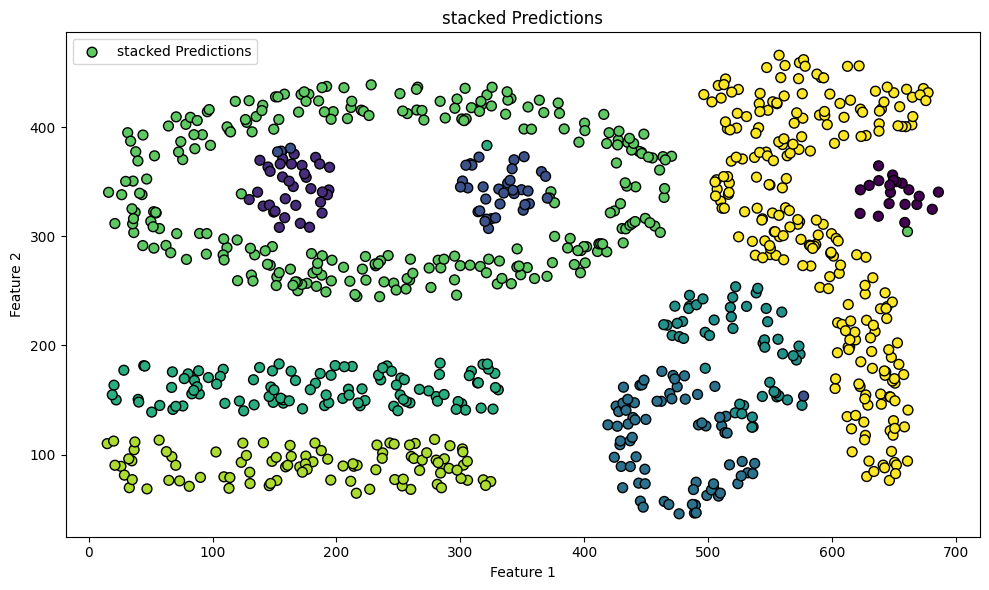

In [153]:
#Initialize base classifiers
base_classifiers = {
    KNeighborsClassifier(n_neighbors=100),
    DecisionTreeClassifier(random_state=42, max_depth=6),
    DecisionTreeClassifier(random_state=42, max_depth=None),
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=10,random_state=42),
    RandomForestClassifier(n_estimators=5,random_state=42)
}

#Initialize the Stacking Classifier with Logistic Regression as the meta-classifier
final_estimator = LogisticRegression()
stacked_clf = CustomStackingClassifier(base_classifiers=base_classifiers, final_estimator=final_estimator)

#Train the Stacking Classifier
stacked_clf.fit(X_train, y_train)

#Predict on training and testing data
y_train_pred_stacked = stacked_clf.predict(X_train)
y_test_pred_stacked = stacked_clf.predict(X_test)

#Evaluate the Stacked Learners algorithm
precision_train_stacked = precision_score(y_train, y_train_pred_stacked, average='macro')
recall_train_stacked = recall_score(y_train, y_train_pred_stacked, average='macro')
f1_train_stacked = f1_score(y_train, y_train_pred_stacked, average='macro')

precision_test_stacked = precision_score(y_test, y_test_pred_stacked, average='macro')
recall_test_stacked = recall_score(y_test, y_test_pred_stacked, average='macro')
f1_test_stacked = f1_score(y_test, y_test_pred_stacked, average='macro')

print("Train results:")
print("Precision:", precision_train_stacked, "/", "F1 Score:", f1_train_stacked, "/", "Recall:", recall_train_stacked)
print("Test results:")
print("Precision:", precision_test_stacked, "/", "F1 Score:", f1_test_stacked, "/", "Recall:", recall_test_stacked)

visualize_classifer_predictions(X_test=X_test2, y_test=y_test2, y_pred=y_test_pred_stacked, classifer_name='stacked Predictions')



### Test stacked learner leave one out

In [154]:
import numpy as np
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Create a more complex dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=42,flip_y=0.5)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define base classifiers, including one that overfits (Decision Tree with high depth)
base_classifiers = [
    KNeighborsClassifier(n_neighbors=100),
    # DecisionTreeClassifier(random_state=42, max_depth=6),
    DecisionTreeClassifier(random_state=42, max_depth=None),
    # AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=10,random_state=42),
    # RandomForestClassifier(n_estimators=5,random_state=42)
]

# Define the final estimator
final_estimator = LogisticRegression(max_iter=200, random_state=42)

# Instantiate the custom stacking classifier
stacking_clf = CustomStackingClassifier(base_classifiers=base_classifiers, final_estimator=final_estimator)

# Fit the stacking classifier
stacking_clf.fit_leave_one_out(X_train, y_train)

# Predict and evaluate on the test set
y_pred = stacking_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.67


# Phase 2

In [355]:
dataset2 = pd.read_csv("datasets/Dataset2.csv")
dataset2.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

In [356]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  TenYearCHD       4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [357]:
dataset2.describe()

male          age    education  currentSmoker   cigsPerDay  \
count  4240.000000  4240.000000  4135.000000    4240.000000  4211.000000   
mean      0.429245    49.580189     1.979444       0.494104     9.005937   
std       0.495027     8.572942     1.019791       0.500024    11.922462   
min       0.000000    32.000000     1.000000       0.000000     0.000000   
25%       0.000000    42.000000     1.000000       0.000000     0.000000   
50%       0.000000    49.000000     2.000000       0.000000     0.000000   
75%       1.000000    56.000000     3.000000       1.000000    20.000000   
max       1.000000    70.000000     4.000000       1.000000    70.000000   

            BPMeds  prevalentStroke  prevalentHyp     diabetes      totChol  \
count  4187.000000      4240.000000   4240.000000  4240.000000  4190.000000   
mean      0.029615         0.005896      0.310613     0.025708   236.699523   
std       0.169544         0.076569      0.462799     0.158280    44.591284   
min       0.000000         0.000000      0.000000     0.000000   107.000000   
25%       0.000000         0.000000      0.000000     0.000000   206.000000   
50%       0.000000         0.000000      0.000000     0.000000   234.000000   
75%       0.000000         0.000000      1.000000     0.000000   263.000000   
max       1.000000         1.000000      1.000000     1.000000   696.000000   

             sysBP        diaBP          BMI    heartRate      glucose  \
count  4240.000000  4240.000000  4221.000000  4239.000000  3852.000000   
mean    132.354599    82.897759    25.800801    75.878981    81.963655   
std      22.033300    11.910394     4.079840    12.025348    23.954335   
min      83.500000    48.000000    15.540000    44.000000    40.000000   
25%     117.000000    75.000000    23.070000    68.000000    71.000000   
50%     128.000000    82.000000    25.400000    75.000000    78.000000   
75%     144.000000    90.000000    28.040000    83.000000    87.000000   
max     295.000000   142.500000    56.800000   143.000000   394.000000   

        TenYearCHD  
count  4240.000000  
mean      0.151887  
std       0.358953  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

## 2.1 Correlation Analysis

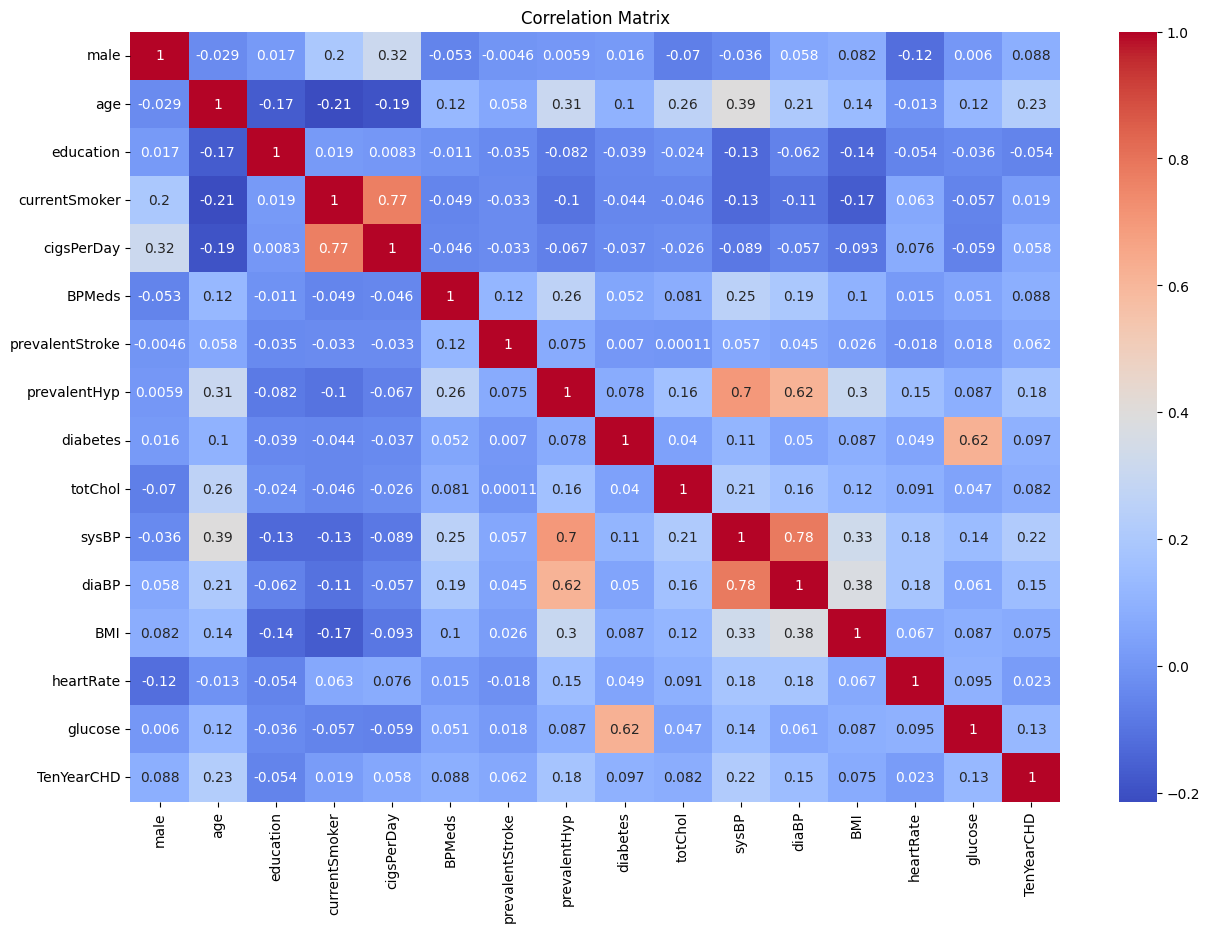

In [358]:
# Plot the correlation matrix
plt.figure(figsize=(15, 10))
correlation_matrix = dataset2.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [359]:
high_correlation_features = ['sysBP', 'cigsPerDay' ]
dataset2.drop(columns=high_correlation_features, axis=1, inplace=True)

## 2.2 Filling Missing Values

In [360]:
print("Number of NaNs in each column:")
print(dataset2.isnull().sum())

Number of NaNs in each column:
male                 0
age                  0
education          105
currentSmoker        0
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [361]:
categorical_features =  [
    'male', 
    'education', 
    'currentSmoker', 
    'BPMeds', 
    'prevalentStroke', 
    'prevalentHyp', 
    'diabetes', 
    'TenYearCHD'
]
continuous_features = ['age', 'totChol', 'diaBP', 'BMI', 'heartRate', 'glucose']

for feat in continuous_features:
    dataset2[feat].fillna(dataset2[feat].mean(), inplace=True)
    
for feat in categorical_features:
    dataset2[feat].fillna(dataset2[feat].mode()[0], inplace=True)
    
print("Number of NaNs in each column:")
print(dataset2.isnull().sum())

Number of NaNs in each column:
male               0
age                0
education          0
currentSmoker      0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64


## 2.3 Train & Test Split

In [386]:
X = dataset2.drop(columns=['TenYearCHD'])
y = dataset2['TenYearCHD']

"""
stratify=y, make sure that both the training and test sets
have the same class distribution as the original dataset.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 2.4 Model Training

In [388]:
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2), n_estimators=50, random_state=42)

base_learners = [
    ('bag', bagging_clf),
    ('rf', rf_clf),
    ('ada', ada_clf),
]
final_learner = LogisticRegression()
stacked_clf = StackingClassifier(estimators=base_learners, final_estimator=final_learner, cv=5)

classifiers = {
    'Bagging': bagging_clf,
    'Random Forest': rf_clf,
    'AdaBoost': ada_clf,
    'Stacked': stacked_clf
}

performance_data_stacked = {
    'Model': [],
    'Dataset': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    add_performance_data(model_name=name, dataset='Train', y_true=y_train,
                      y_pred=y_train_pred, performance_data=performance_data_stacked)
    add_performance_data(model_name=name, dataset='Test', y_true=y_test,
                      y_pred=y_test_pred, performance_data=performance_data_stacked)

performance_df_stacked = pd.DataFrame(performance_data_stacked)

performance_df_stacked


Model Dataset  Precision    Recall  F1-Score
0        Bagging   Train   1.000000  1.000000  1.000000
1        Bagging    Test   0.772694  0.836085  0.788739
2  Random Forest   Train   1.000000  1.000000  1.000000
3  Random Forest    Test   0.783530  0.844340  0.788441
4       AdaBoost   Train   0.852200  0.869988  0.843496
5       AdaBoost    Test   0.759806  0.813679  0.780772
6        Stacked   Train   0.999705  0.999705  0.999705
7        Stacked    Test   0.814701  0.850236  0.791851